## Van Gogh

In [1]:
import xml.etree.ElementTree as ET
import os
from os.path import join
import re
import string
from nltk import word_tokenize,sent_tokenize,pos_tag
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords

ns = { 'tei':'http://www.tei-c.org/ns/1.0'}

The XML files were downloaded from the [Van Gogh Letters website](https://vangoghletters.org/vg/about_6.html#intro.VI.6.4.)

In [2]:
dir = 'VanGogh'
metadata = dict()

xml_files = os.listdir(dir)
xml_files = [file for file in xml_files if re.search( r'xml$',file)]

for letter in xml_files:    


    with open(join(dir,letter), 'r',encoding='utf-8') as xml_file:
        xml_tree = ET.parse(xml_file)
        root = xml_tree.getroot()

        date = root.find( 'tei:teiHeader/tei:fileDesc/tei:titleStmt' , ns )
        year = ''.join(date.itertext())
        match = re.search(r'\d{4}',year)
        if match: 
            year = match.group(0)
        
        tei_text = root.find( 'tei:text' , ns )    
        full_text = ''.join(tei_text.itertext())
        full_text = re.sub(r'\s+',' ',full_text)
        
        out_file = re.sub(r'\.xml','.txt',letter)
        metadata[join(out_file)] = year
        
        with open(join(dir,out_file),'w',encoding='utf-8') as out:
            out.write(full_text)


In [3]:
txt_files = os.listdir(dir)
txt_files = [file for file in txt_files if re.search( r'txt$',file)]
data = []
string.punctuation += '-•“”’– '


for letter in txt_files:

    row = []
    text = open(join(dir,letter),encoding='utf-8')
    full_text = text.read()
    
    full_text_no_spaces = re.sub( r'[{}]'.format(string.punctuation),'',full_text)
    nr_characters = len(full_text_no_spaces)
    words = word_tokenize(full_text.lower())
    
    words = [word for word in words if word not in string.punctuation]
    
    nr_tokens = len(words)
    avg_word_length = nr_characters / nr_tokens
    
    row.append(nr_tokens)
    row.append(avg_word_length)
    
    sentences = word_tokenize(full_text)
    nr_sentences = len(sentences)
    row.append(nr_sentences)
    
    row.append(nr_tokens/nr_sentences)
    
    first_100 = words[:100]
    unique = list(set(first_100))
    ttr = len(unique)/len(first_100)
    row.append(ttr)
    row.append(metadata[letter])

    row.append(letter)
    
    data.append(row)
    
columns = ['nr_tokens','word_length','nr_sentences','words_per_sentence','ttr','year','title']
df = pd.DataFrame(data, columns = columns)
df.head()


,nr_tokens,word_length,nr_sentences,words_per_sentence,ttr,year,title
0,2027,4.046867,2306,0.879011,0.75,1886,let553.txt
1,5130,4.371540,6084,0.843195,0.80,1882,let235.txt
2,2668,4.058846,3046,0.875903,0.79,1882,let221.txt
3,4159,4.376292,4701,0.884705,0.75,1885,let547.txt
4,1840,4.064130,2048,0.898438,0.75,1882,let209.txt


In [4]:

def describe_period(year):
    period = ''
    if year < 1881:
        period = 'Zundert'
    elif year < 1883:
        period = 'Drenthe_TheHague'
    elif year < 1886:
        period = 'Nuenen_Antwerp'
    elif year < 1888:
        period = 'Paris'
    else:
        period = 'Arles'
    return period
       
df['period'] = df['year'].astype('int64').apply(describe_period)

df = df.sort_values(by='year')

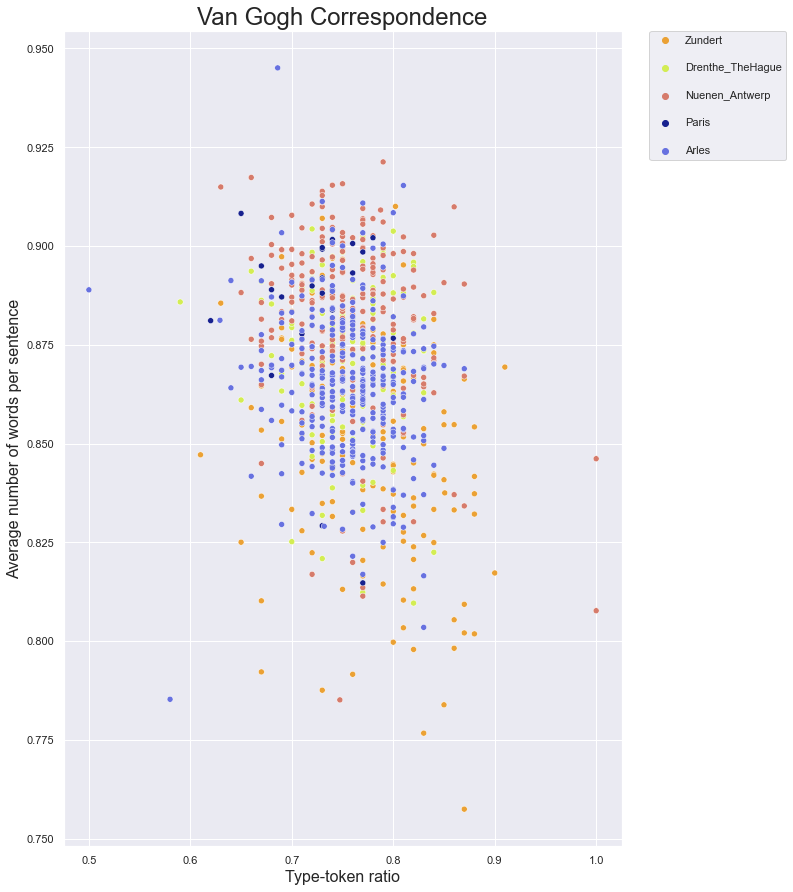

In [5]:

x_axis = 'ttr'
y_axis =  'words_per_sentence'
hue = 'period'


#colours = sns.color_palette('colorblind',5)
colours = ['#eba134','#d3ed53','#d67b6b','#17218f','#6771e0']

fig = plt.figure( figsize = ( 10,15 ))

## This line adds spacing in between the lines of the legend 
sns.set(rc = {'legend.labelspacing': 1.6})

ax = sns.scatterplot( data=df, x=x_axis, y=y_axis,  
                     hue= hue, palette = colours )

# for index, row in df.iterrows():
#     plt.text( row[x_axis], row[y_axis]+ 0.001 , row['title'] , fontsize=12.8)


ax.set_xlabel( 'Type-token ratio'  , fontsize = 16 )
ax.set_ylabel( 'Average number of words per sentence'  , fontsize = 16 )
ax.set_title( 'Van Gogh Correspondence' , fontsize=24 )


# this next line places the legend outside of the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

plt.savefig( 'scatterplot.png' , dpi=300 )